In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import os

# Load dataset
files = ['./dataset/MA-A.xlsx', './dataset/NORTHBOUND.xlsx', './dataset/SOUTHBOUND.xlsx']
sheets = ["2018", "2019", "2020", "2021", "2022", "2023"]

def load_and_preprocess_data(files, sheets):
    df_list = []
    for file in files:
        if os.path.exists(file):
            for sheet in sheets:
                try:
                    temp_df = pd.read_excel(file, sheet_name=sheet)
                    
                    # Drop 'TRAFFIC STATUS' column if present
                    temp_df.drop(columns=['TRAFFIC STATUS'], errors='ignore', inplace=True)

                    temp_df['TIME(24 HOUR)'] = temp_df['TIME(24 HOUR)'].astype(str).str.zfill(5) + ':00'
                    temp_df['Datetime'] = pd.to_datetime(
                        temp_df['DATE'].astype(str) + ' ' + temp_df['TIME(24 HOUR)'],
                        dayfirst=True, errors='coerce'
                    )
                    temp_df = temp_df.dropna(subset=['Datetime']).sort_values('Datetime')

                    # Extract time features
                    temp_df['Hour'] = temp_df['Datetime'].dt.hour
                    temp_df['DayOfWeek'] = temp_df['Datetime'].dt.dayofweek
                    temp_df['Month'] = temp_df['Datetime'].dt.month

                    df_list.append(temp_df)
                except Exception as e:
                    print(f"Error loading {file} - {sheet}: {e}")

    return pd.concat(df_list, ignore_index=True) if df_list else None

df = load_and_preprocess_data(files, sheets)

# One-hot encoding for categorical features
df = pd.get_dummies(df, columns=['DAY OF THE WEEK', 'WEATHER', 'ROAD CONDITION', 'HOLIDAY'], drop_first=True)

# Define target and features
target_column = 'TRAFFIC VOLUME'
features = df.drop([target_column, 'DATE', 'TIME(24 HOUR)', 'Datetime'], axis=1)
target = df[target_column]

# Scale input and output
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1)).flatten()

def create_sequences(data, targets, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon):
        X.append(data[i:i + window_size])
        y.append(targets[i + window_size : i + window_size + forecast_horizon])
    return np.array(X), np.array(y)

# Define window and forecast horizon
window_size = 24
forecast_horizon = 24

X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size, forecast_horizon)

# Train-test split
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# Build LSTM Seq2Seq Model
encoder_inputs = Input(shape=(window_size, X_train.shape[2]))
encoder_lstm = LSTM(128, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = RepeatVector(forecast_horizon)(encoder_outputs)
decoder_lstm = LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)

output_layer = TimeDistributed(Dense(1, activation="linear"))(decoder_outputs)

model = Model(inputs=encoder_inputs, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error", metrics=["mae"])

# Train Model
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Evaluate model on test set
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

Epoch 1/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - loss: 0.0218 - mae: 0.1055 - val_loss: 0.0100 - val_mae: 0.0761
Epoch 2/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - loss: 0.0120 - mae: 0.0747 - val_loss: 0.0108 - val_mae: 0.0782
Epoch 3/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 0.0101 - mae: 0.0668 - val_loss: 0.0177 - val_mae: 0.1007
Epoch 4/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 0.0091 - mae: 0.0625 - val_loss: 0.0149 - val_mae: 0.0903
Epoch 5/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 0.0083 - mae: 0.0595 - val_loss: 0.0081 - val_mae: 0.0652
Epoch 6/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 0.0079 - mae: 0.0575 - val_loss: 0.0075 - val_mae: 0.0610
Epoch 7/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 0.0073 - mae: 0.0552 - val_loss: 0.0119 - val_mae: 0.0794
Epoch 8/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 0.0068 - mae: 0.0534 - val_loss: 0.0104 - val_mae: 0.0731
Epoch 9/100
622/622 ━━━━━━━━━━━━

In [47]:
# Evaluate model on test set
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate metrics
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R² Score: {r2:.4f}")

389/389 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Test MAE: 451.23
Test RMSE: 641.39
Test R² Score: 0.7785


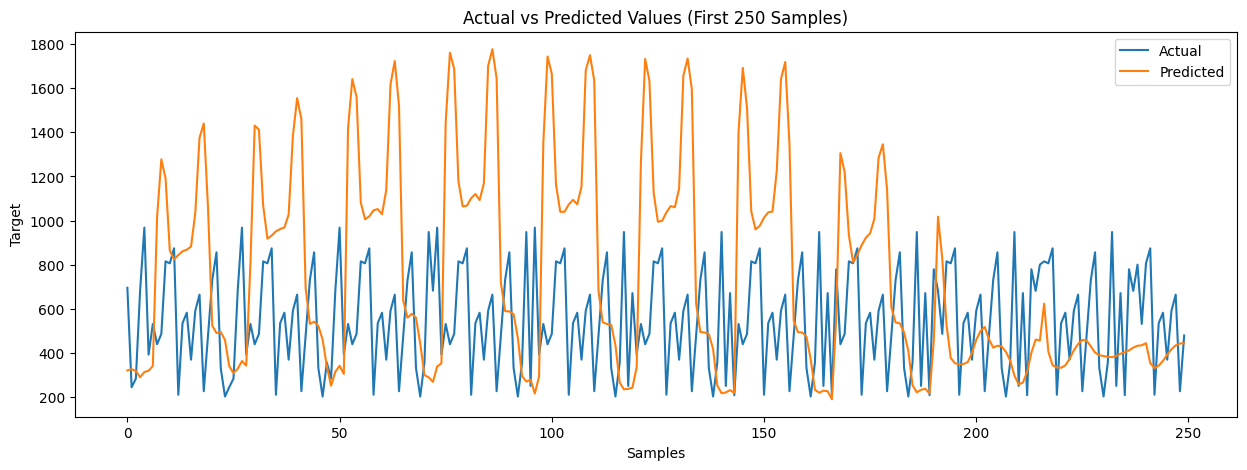

In [48]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual[:250], label="Actual")
plt.plot(y_pred[:250], label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

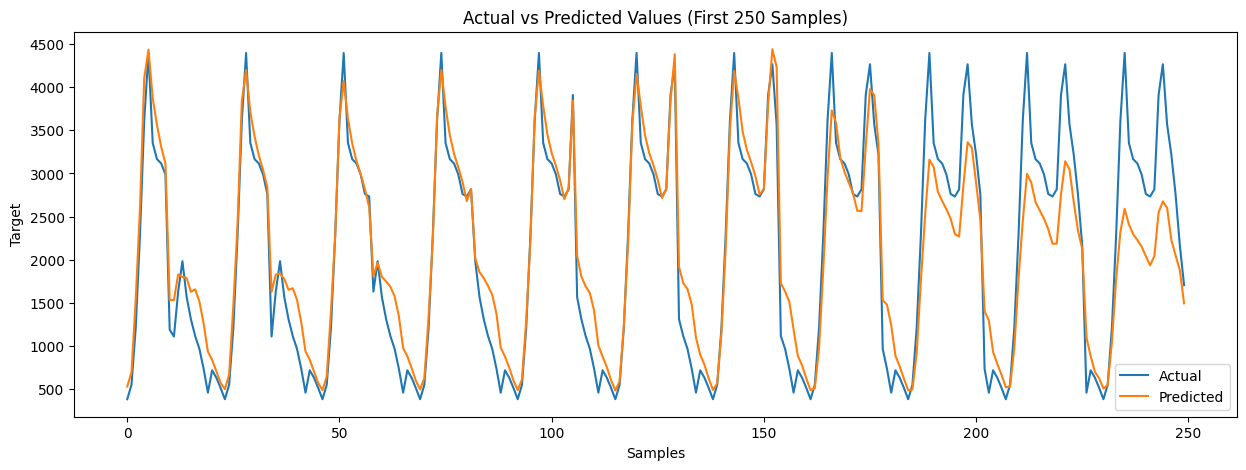

In [49]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual[-250:], label="Actual")
plt.plot(y_pred[-250:], label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

In [42]:
# Save the model
model.save("traffic_model.h5")

# Save feature scaler
joblib.dump(scaler_X, "scaler_X.pkl")

# Save target scaler
joblib.dump(scaler_y, "scaler_y.pkl")

['scaler_y.pkl']